In [2]:
import pandas as pd
import numpy as np
import datetime as dt

In [1]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, roc_auc_score, \
classification_report
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import catboost
from catboost import *
from category_encoders import TargetEncoder, BackwardDifferenceEncoder, CatBoostEncoder
import scipy

In [3]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
sns.set(rc={'figure.figsize':(24, 12)})

## Загрузка датасета и анализ данных

In [4]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test_dataset_test.csv')

In [5]:
l = ['Возраст курения', 'Сигарет в день', 'Частота пасс кур', 'Возраст алког']
for i in l:
    df[i].fillna(0, inplace=True)
for i in l:
    test[i].fillna(0, inplace=True)

### Дополнение признака времени сна

In [6]:
def get_sleep_time(df):

    dateparser = lambda x: dt.datetime.strptime(x, "%H:%M:%S")
    df['sleeptime'] = ((df['Время пробуждения'].apply(dateparser)+dt.timedelta(days=1))-df['Время засыпания'] \
                           .apply(dateparser))/pd.Timedelta(1, 'h')
    
    for i in range(len( df['sleeptime'])):
        if  df['sleeptime'][i] > 24:
            df['sleeptime'][i] =  df['sleeptime'][i] - 24
    #Для прочих, которые имеют выбросы усредняем значение, которое возьмем равное 7 часам
    for i in  range(len(df['sleeptime'])):
        if df['sleeptime'][i]>17 or df['sleeptime'][i]<=0:
            df['sleeptime'][i] = 7.0
    
    return df

In [7]:
get_sleep_time(df)
get_sleep_time(test)

C:\Users\DERIAB~1\AppData\Local\Temp/ipykernel_20804/3191990968.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sleeptime'][i] =  df['sleeptime'][i] - 24
C:\Users\DERIAB~1\AppData\Local\Temp/ipykernel_20804/3191990968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sleeptime'][i] = 7.0


,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,...,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",sleeptime
0,54-001-019-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,...,0,0,употребляю в настоящее время,23.0,21:30:00,05:00:00,0,1,1,7.5
1,54-002-133-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,...,0,0,употребляю в настоящее время,22.0,00:00:00,09:00:00,0,0,0,9.0
2,54-001-007-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,...,0,0,употребляю в настоящее время,18.0,23:00:00,07:30:00,0,0,0,8.5
3,54-102-116-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,низкоквалифицированные работники,1,0,...,0,0,никогда не употреблял,0.0,22:00:00,06:00:00,0,0,0,8.0
4,54-502-005-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,1,...,0,0,употребляю в настоящее время,19.0,22:00:00,06:00:00,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,54-102-095-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,1,0,...,0,0,употребляю в настоящее время,30.0,23:00:00,06:00:00,0,0,0,7.0
634,54-102-235-01,Ж,вдовец / вдова,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,...,0,0,никогда не употреблял,0.0,01:00:00,10:00:00,0,0,0,9.0
635,54-502-016-01,Ж,гражданский брак / проживание с партнером,европейская,Русские,Христианство,4 - профессиональное училище,техники и младшие специалисты,1,0,...,1,не менее 1 раза в день,ранее употреблял,25.0,22:00:00,07:00:00,0,0,0,9.0
636,54-002-138-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,"работники, занятые в сфере обслуживания, торг...",1,0,...,1,2-3 раза в день,никогда не употреблял,0.0,00:00:00,08:00:00,0,0,0,8.0


In [8]:
df['Пол'][304] = 'М'

C:\Users\DERIAB~1\AppData\Local\Temp/ipykernel_20804/9164562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Пол'][304] = 'М'


## Исследование признаков

<AxesSubplot:xlabel='Возраст курения', ylabel='Count'>

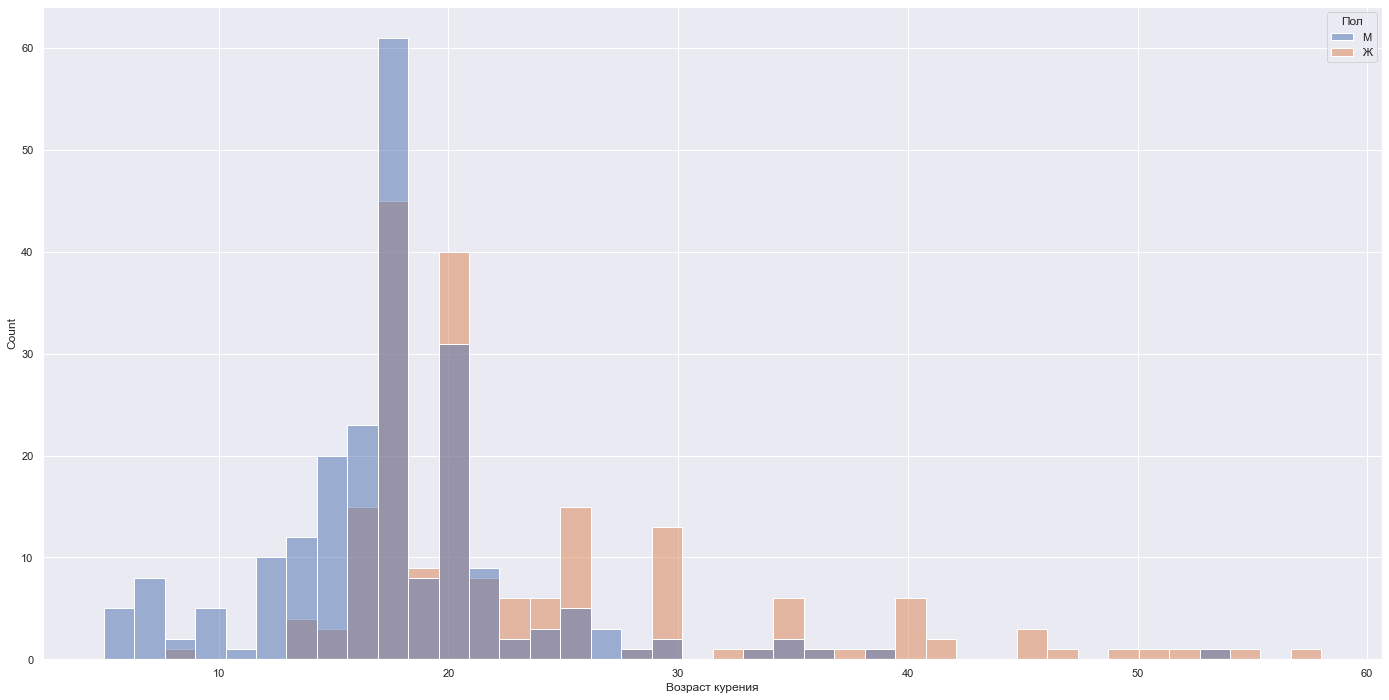

In [9]:
sns.histplot(data=df.loc[df['Возраст курения'] != 0], x='Возраст курения', hue='Пол')

<AxesSubplot:xlabel='sleeptime', ylabel='Count'>

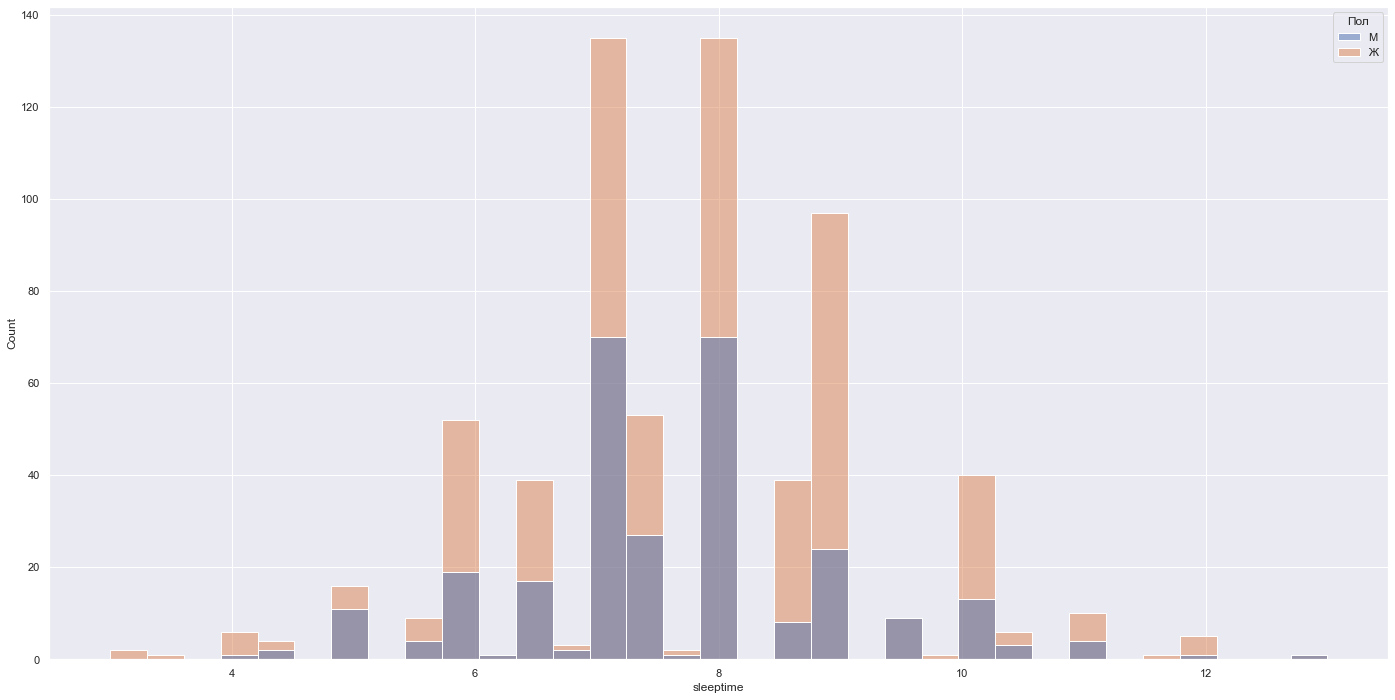

In [10]:
sns.histplot(data=df, x='sleeptime', hue='Пол')

<AxesSubplot:xlabel='Сигарет в день', ylabel='Count'>

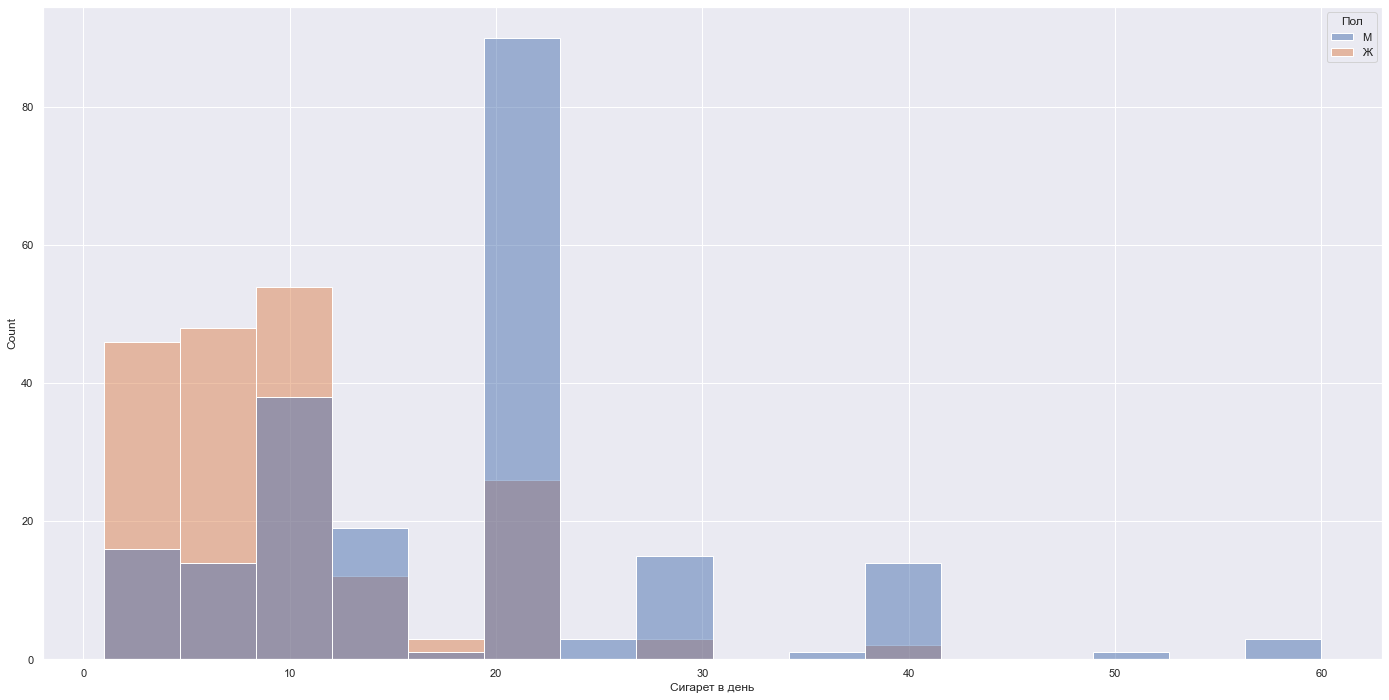

In [11]:
sns.histplot(data=df.loc[df['Сигарет в день'] != 0], x='Сигарет в день', hue='Пол')

<AxesSubplot:xlabel='Возраст алког', ylabel='Count'>

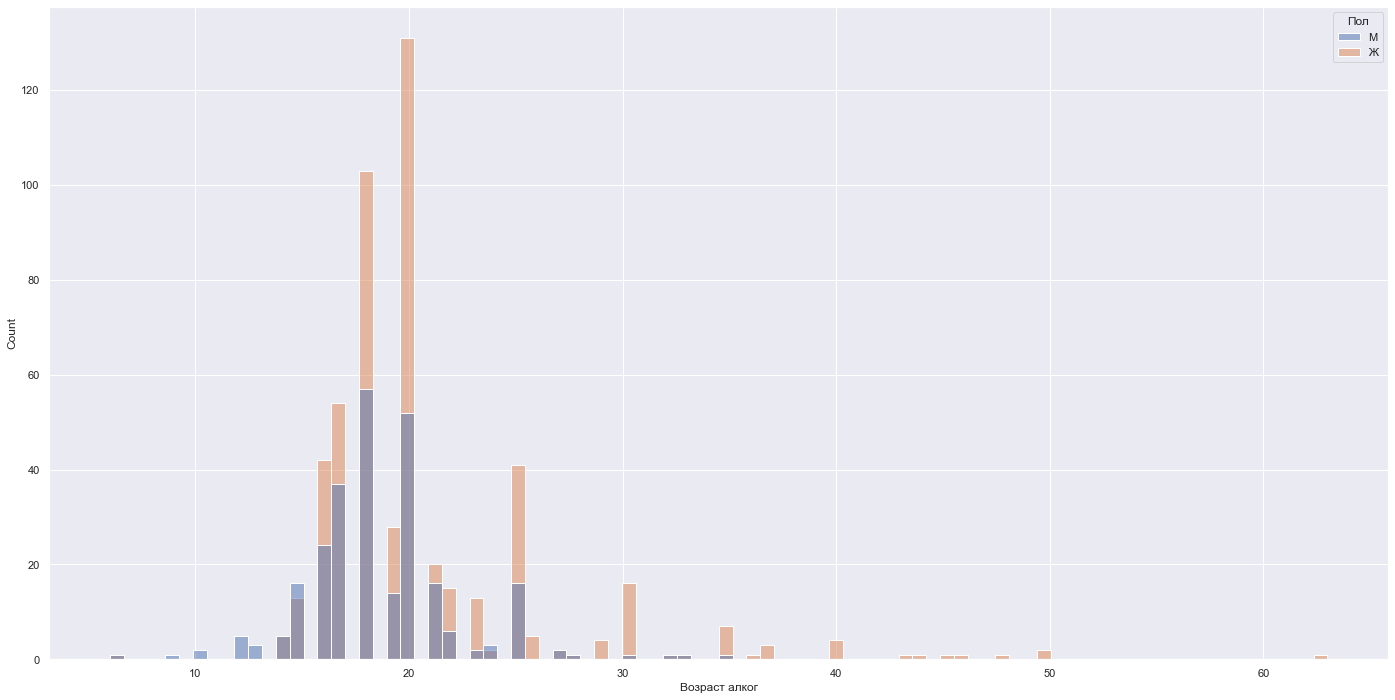

In [12]:
sns.histplot(data=df.loc[df['Возраст алког'] != 0], x='Возраст алког', hue='Пол')

In [13]:
df.groupby(['Пол']).agg({'Пол':'count', 'Артериальная гипертензия':'sum',
                'ОНМК':'sum', 'Стенокардия, ИБС, инфаркт миокарда':'sum',
                'Сердечная недостаточность':'sum', 'Прочие заболевания сердца':'sum'})

,Пол,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
Пол,,,,,,
Ж,667,338,22,81,78,71
М,288,108,19,36,18,15


<AxesSubplot:>

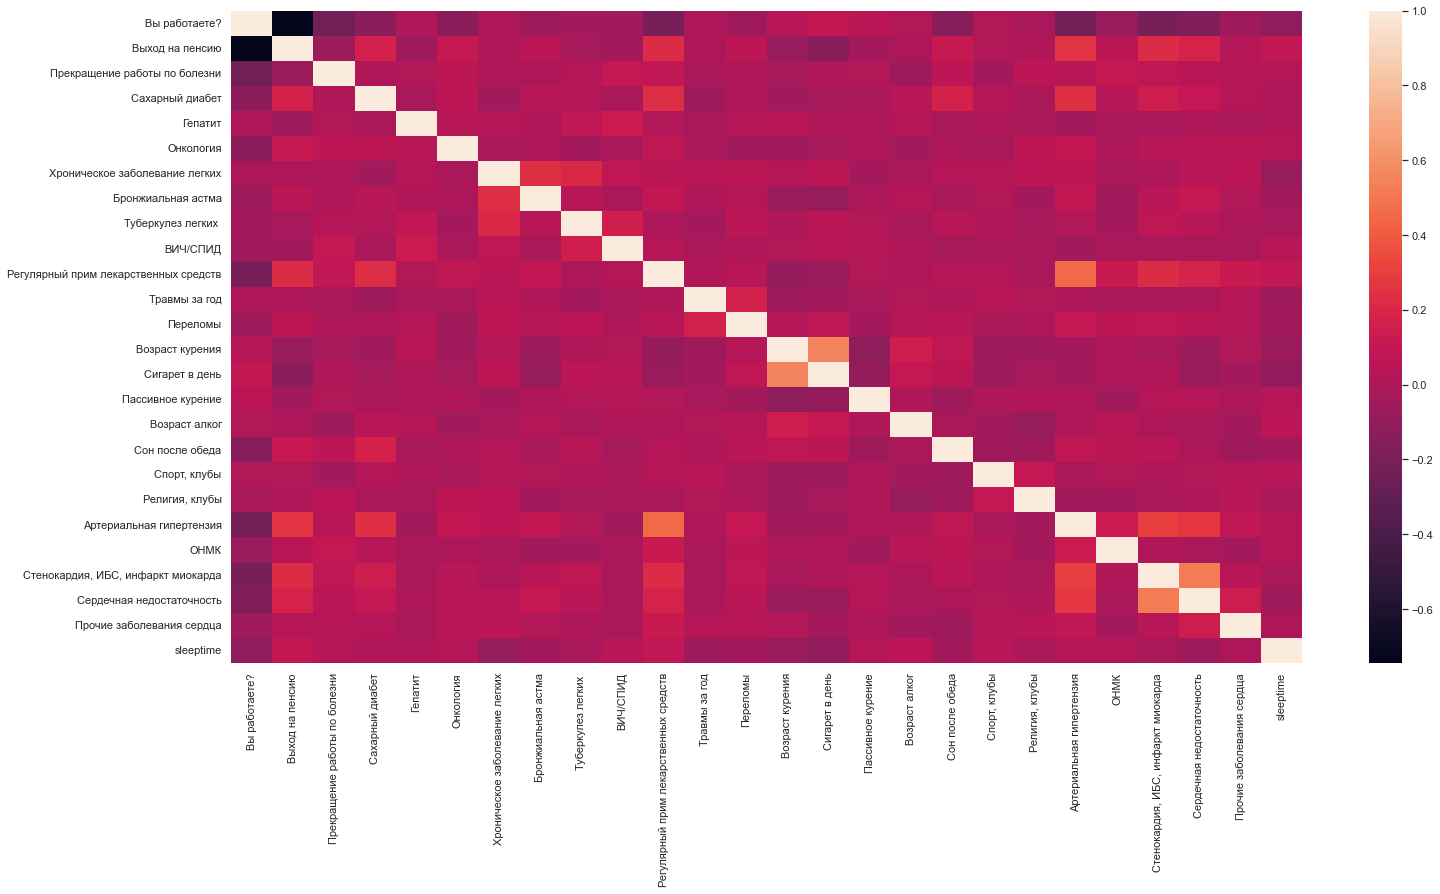

In [14]:
sns.heatmap(df.corr())

Прослеживается зависимость между приемом лекарственных средств и артериальной гипертензией и другими болезнями как сердечно-сосудистой системы, так и прочими болезнями. Но следует учитывать, что регулярный прием лекарственных средств может являться следствием болезней сердечно-сосудистой системы, поэтому к данному признаку необходимо отнестись с осторожностью

## Кодирование признаков и формирование списка признаков для каждой целевой переменной

Для кодирования будет использована методика  mean target encoding, так как данных не очень много и значительное количество переменных.

In [19]:
numeric_cols = ['Возраст курения', 'Сигарет в день', 'Возраст алког', 'sleeptime']
target_cols = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',
                'Сердечная недостаточность', 'Прочие заболевания сердца']
categorical_num_cols = list(set(df._get_numeric_data().columns) - set(numeric_cols) - set(target_cols))
categorical_cols = list(set(df.columns) - set(df._get_numeric_data().columns) - set(['ID', 'ID_y', 'Время засыпания',
                                                                                     'Время пробуждения', 'Этнос',
                                                                                     'Национальность']))

## Обучение модели

Общая функция для обучения модели с подобранными наилучшими параметрами для каждого класса

In [39]:
def modeling_cvd(df, test):
    #подготвка DF для ответов
    result = pd.DataFrame(columns=[target_cols])
    encoder = TargetEncoder()
    
    bad_habits = ['Пассивное курение','Частота пасс кур', 'Возраст алког', 'Возраст курения', 'Алкоголь',  'Статус Курения']
    #Обучение модели по лучшим гиперпараметрам
    for i in target_cols:
    
        #осуществляем target encoding
        encoder.fit(df[categorical_cols], df[i])
        df_dop = encoder.transform(df[categorical_cols])
        test_dop = encoder.transform(test[categorical_cols])
        test_dop = pd.concat([test_dop, test[numeric_cols+categorical_num_cols]], axis=1)
        
        df_dop = pd.concat([df_dop, df[numeric_cols+categorical_num_cols], df[i]], axis=1)
    
        dop = pd.concat([df_dop, test_dop], axis = 0)
        X, y= dop.drop(i, axis=1), df[i]
    
        #производим понижение размерности
        X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X[bad_habits])
    
        #производим кластеризаию данных на 30 кластеров
        clusters = AgglomerativeClustering(n_clusters=30, affinity='euclidean', linkage='ward')
        cluster = clusters.fit_predict(X_embedded)
        
        X['clusters'] = cluster
    
        #разделяем тестовую и тренировочную выборки
        X_test = X.tail(638)
        X = X.head(955)
    
        #производим расчет коэффициентов дисбаланса классов
        w0 = (sum(y)/955)
        w1 = 1 - (sum(y)/955)
        class_weight = {0:w0, 1:w1}
    
        #обучение модели, в ходе исследований были получены оптимальные гиперпараметры, которые использованы
        model = CatBoostClassifier(
                                iterations=100,
                                learning_rate=0.005,
                                class_weights=class_weight,
                                bootstrap_type = 'Bayesian',
                                grow_policy = 'Depthwise',
                                random_seed = 42,
                                bagging_temperature = 0.05
                                )
        model.fit(X, y,
              verbose=False
             )
    
        #предсказание и запись результата
        result[i] = model.predict(X_test)
    
    return result

In [56]:
result = modeling_cvd(df, test)

In [57]:
result.sum()

Артериальная гипертензия              339
ОНМК                                   62
Стенокардия, ИБС, инфаркт миокарда    151
Сердечная недостаточность             139
Прочие заболевания сердца             138
dtype: int64